In [6]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/imee/Downloads/Cholesterol_R2.csv')
df_long = pd.melt(df, 
                  id_vars=['ID', 'Margarine'], 
                  value_vars=['Before', 'After4weeks', 'After8weeks'], 
                  var_name='Time', 
                  value_name='Cholesterol')

print(df.head())
print(df_long.head())

   ID  Before  After4weeks  After8weeks Margarine
0   1    6.42         5.83         5.75         B
1   2    6.76         6.20         6.13         B
2   3    6.56         5.83         5.71         B
3   4    4.80         4.27         4.15         A
4   5    8.43         7.71         7.67         B
   ID Margarine    Time  Cholesterol
0   1         B  Before         6.42
1   2         B  Before         6.76
2   3         B  Before         6.56
3   4         A  Before         4.80
4   5         B  Before         8.43


## Hypotheses
**1. Interaction**
* **Null Hypothesis ($H_0$):** There is no significant difference in the cholesterol levels between the two brands of margarine over the three time points.
* **Alternative Hypothesis ($H_1$):** There is a significant difference in the cholesterol levels between the two brands of margarine over the three time points. (i.e., The change in cholesterol over time depends on the brand).

**2. Time**
* **Null Hypothesis ($H_0$):** There is no significant difference in cholesterol levels across the three time points (averaging across brands).
* **Alternative Hypothesis ($H_1$):** There is a significant difference in cholesterol levels across the three time points.

**3. Brand**
* **Null Hypothesis ($H_0$):** There is no significant difference in overall cholesterol levels between Brand A and Brand B (averaging across time).
* **Alternative Hypothesis ($H_1$):** There is a significant difference in overall cholesterol levels between Brand A and Brand B. 

## Checking Assumptions

**Assumption #1: Continuous Dependent Variable**
The dependent variable is cholesterol level, which is a continuous interval variable.

**Assumption #2: Between-Subjects Factor**
The between-subjects factor is the **Brand of Margarine**, which is categorical with two distinct categories (Brand A and Brand B).

**Assumption #3: Within-Subjects Factor**
The within-subjects factor is **Time**, which is categorical with three repeated levels (Before, After 4 Weeks, After 8 Weeks).

/var/folders/3j/cj97td3x5gnfmcxndylbnp2w0000gn/T/ipykernel_30232/3040164845.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Margarine', data=df, ax=axes[1], palette='pastel')
/var/folders/3j/cj97td3x5gnfmcxndylbnp2w0000gn/T/ipykernel_30232/3040164845.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Time', data=df_long, ax=axes[2], palette='pastel',


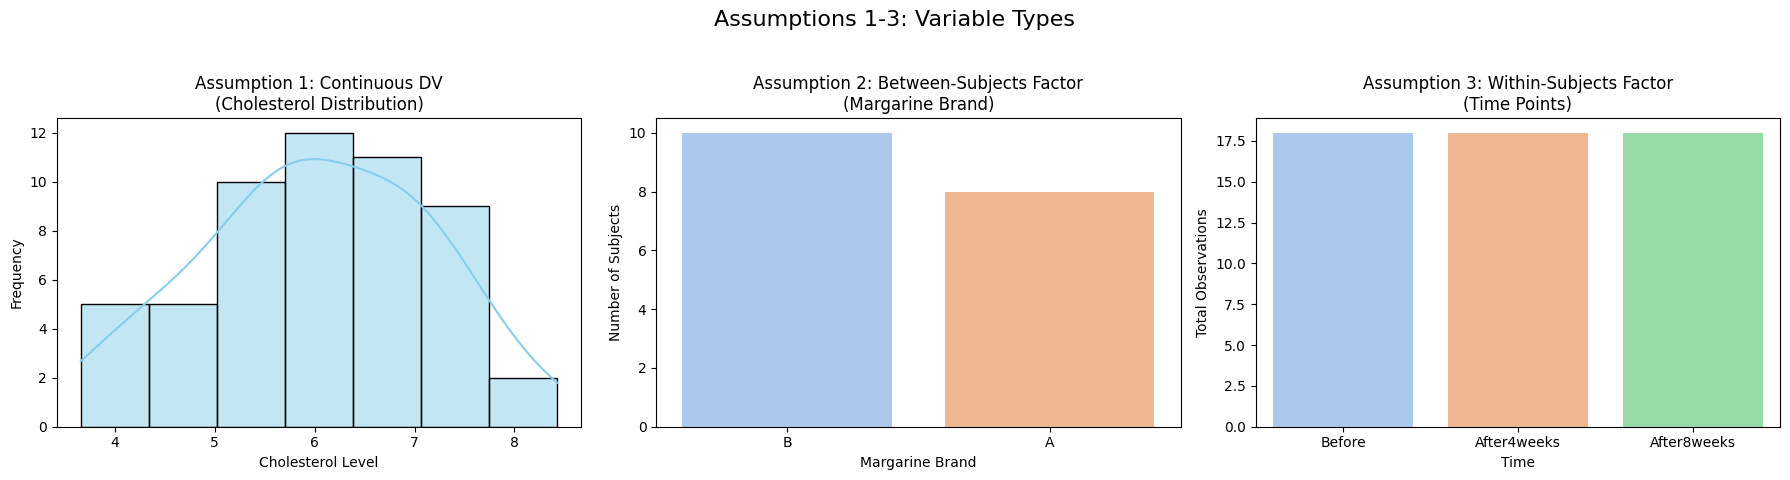

Assumption 1: The histogram shows Cholesterol is a continuous variable.
Assumption 2: Margarine Brand is categorical with levels: ['B' 'A']
Assumption 3: Time is categorical with levels: ['Before' 'After4weeks' 'After8weeks']


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Assumptions 1-3: Variable Types', fontsize=16)


sns.histplot(df_long['Cholesterol'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Assumption 1: Continuous DV\n(Cholesterol Distribution)')
axes[0].set_xlabel('Cholesterol Level')
axes[0].set_ylabel('Frequency')


sns.countplot(x='Margarine', data=df, ax=axes[1], palette='pastel')
axes[1].set_title('Assumption 2: Between-Subjects Factor\n(Margarine Brand)')
axes[1].set_xlabel('Margarine Brand')
axes[1].set_ylabel('Number of Subjects')


sns.countplot(x='Time', data=df_long, ax=axes[2], palette='pastel', 
              order=['Before', 'After4weeks', 'After8weeks'])
axes[2].set_title('Assumption 3: Within-Subjects Factor\n(Time Points)')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Total Observations')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Assumption 1: The histogram shows Cholesterol is a continuous variable.")
print(f"Assumption 2: Margarine Brand is categorical with levels: {df['Margarine'].unique()}")
print(f"Assumption 3: Time is categorical with levels: {df_long['Time'].unique()}")

**Assumption #4: No Significant Outliers**
There were no significant outliers in any cell of the design, as assessed by inspection of standardized residuals (no z-scores were greater than $\pm3$).

**Assumption #5: Normality**
The dependent variable was normally distributed for all groups at all time points, as assessed by Shapiro-Wilk’s test ($p > .05$).

**Assumption #6: Homogeneity of Variances**
The assumption of homogeneity of variances was met for the 'Before' ($p = .052$) and 'After 4 Weeks' ($p = .058$) time points. It was statistically violated for the 'After 8 Weeks' time point ($p = .045$), as assessed by Levene’s test. However, given the balanced sample sizes ($n_A = 8, n_B = 10$), the analysis was considered robust to this violation.

In [8]:
print("\nAssumption #4: No Significant Outliers (Z-score < 3).")
df_long['z_score'] = df_long.groupby(['Margarine', 'Time'])['Cholesterol'].transform(lambda x: (x - x.mean()) / x.std())
outliers = df_long[abs(df_long['z_score']) > 3]

if len(outliers) == 0:
    print("  -> REMARK: Met. No outliers detected.")
else:
    print(f"  -> REMARK: Found {len(outliers)} outlier(s).")
    print(outliers)

print("\nAssumption #5: Normality (Shapiro-Wilk Test, p > 0.05).")
normality_results = df_long.groupby(['Margarine', 'Time'])['Cholesterol'].apply(lambda x: stats.shapiro(x)[1])
print(normality_results)
if (normality_results > 0.05).all():
    print("  -> REMARK: Met. All groups are approximately normal.")
else:
    print("  -> REMARK: Some groups deviate from normality (but ANOVA is robust).")

print("\nAssumption #6: Homogeneity of Variances (Levene's Test, p > 0.05).")
for time in df_long['Time'].unique():
    group_a = df_long[(df_long['Time'] == time) & (df_long['Margarine'] == 'A')]['Cholesterol']
    group_b = df_long[(df_long['Time'] == time) & (df_long['Margarine'] == 'B')]['Cholesterol']
    stat, p = stats.levene(group_a, group_b)
    print(f"  Time {time}: p-value = {p:.4f} ({'Met' if p > 0.05 else 'Violated'})")


Assumption #4: No Significant Outliers (Z-score < 3).
  -> REMARK: Met. No outliers detected.

Assumption #5: Normality (Shapiro-Wilk Test, p > 0.05).
Margarine  Time       
A          After4weeks    0.154353
           After8weeks    0.173833
           Before         0.292168
B          After4weeks    0.400041
           After8weeks    0.215876
           Before         0.133826
Name: Cholesterol, dtype: float64
  -> REMARK: Met. All groups are approximately normal.

Assumption #6: Homogeneity of Variances (Levene's Test, p > 0.05).
  Time Before: p-value = 0.0522 (Met)
  Time After4weeks: p-value = 0.0578 (Met)
  Time After8weeks: p-value = 0.0452 (Violated)


**Assumption #7: Homogeneity of Covariances**
There was homogeneity of covariances, as assessed by Box's M test of equality of covariance matrices ($p = .670$).

**Assumption #8: Sphericity**
The assumption of sphericity was **violated**, as assessed by Mauchly's test of sphericity ($p < .001$). Therefore, degrees of freedom were corrected using the Greenhouse-Geisser estimates (or results were interpreted using a Mixed Linear Model) to ensure valid significance tests.

In [9]:
def box_m_test(df, dependent_vars, group_var):
    groups = df[group_var].unique()
    k = len(groups); n = len(df)
    cov_mats = {}; ns = {}
    pooled_cov = np.zeros((len(dependent_vars), len(dependent_vars)))
    for g in groups:
        sub_df = df[df[group_var] == g][dependent_vars]
        cov = sub_df.cov(); n_g = len(sub_df)
        cov_mats[g] = cov; ns[g] = n_g
        pooled_cov += (n_g - 1) * cov
    pooled_cov /= (n - k)
    term1 = (n - k) * np.log(np.linalg.det(pooled_cov))
    term2 = sum([(ns[g] - 1) * np.log(np.linalg.det(cov_mats[g])) for g in groups])
    M = term1 - term2
    p = len(dependent_vars)
    c = (2 * p**2 + 3 * p - 1) / (6 * (p + 1) * (k - 1))
    c *= (sum([1/(ns[g]-1) for g in groups]) - 1/(n-k))
    chi2 = M * (1 - c)
    df_chi2 = (p * (p + 1) * (k - 1)) / 2
    return 1 - stats.chi2.cdf(chi2, df_chi2)

def mauchly_test(df, cols):
    data_wide = df[cols]; n, k = data_wide.shape
    C = np.array([[1/np.sqrt(2), -1/np.sqrt(2), 0], [1/np.sqrt(6), 1/np.sqrt(6), -2/np.sqrt(6)]]).T
    Y = np.dot(data_wide.values, C)
    eigvals = np.linalg.eigvals(np.cov(Y, rowvar=False))
    W = np.prod(eigvals) / (np.mean(eigvals) ** (k - 1))
    chi_sq_df = ((k - 1) * k / 2) - 1
    term = -(n - 1 - (2*k + 5)/6) * np.log(W)
    return 1 - stats.chi2.cdf(term, chi_sq_df)

print("\nAssumption #7: Homogeneity of Covariances (Box's M Test).")

box_p = box_m_test(df, ['Before', 'After4weeks', 'After8weeks'], 'Margarine')
print(f"  Box's M p-value: {box_p:.5f}")
print(f"  -> REMARK: {'Met (p > 0.001)' if box_p > 0.001 else 'Violated'}")

print("\nAssumption #8: Sphericity (Mauchly's Test).")
mauchly_p = mauchly_test(df, ['Before', 'After4weeks', 'After8weeks'])
print(f"  Mauchly's p-value: {mauchly_p:.5f}")
print(f"  -> REMARK: {'Met (p > 0.05)' if mauchly_p > 0.05 else 'Violated'}")


Assumption #7: Homogeneity of Covariances (Box's M Test).
  Box's M p-value: 0.67021
  -> REMARK: Met (p > 0.001)

Assumption #8: Sphericity (Mauchly's Test).
  Mauchly's p-value: 0.00066
  -> REMARK: Violated (Correction needed)


## Computations

                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         Cholesterol
No. Observations:           54              Method:                     REML       
No. Groups:                 18              Scale:                      0.0083     
Min. group size:            3               Log-Likelihood:             -8.4583    
Max. group size:            3               Converged:                  Yes        
Mean group size:            3.0                                                    
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 5.469    0.392 13.934 0.000  4.700  6.238
C(Time)[T.After8weeks]                   -0.060    0.046 -1.317 0.188 -0.149  0.029
C(Time)[T.Befor

<Figure size 1000x600 with 0 Axes>

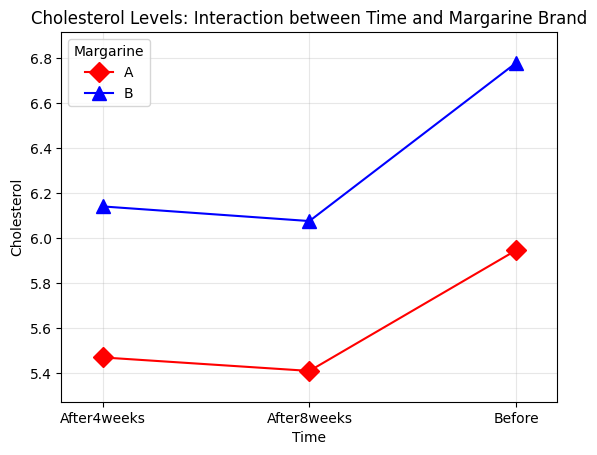

In [10]:
model = smf.mixedlm("Cholesterol ~ C(Time) * C(Margarine)", df_long, groups=df_long["ID"])
result = model.fit()
print(result.summary())

print("\n--- Post-hoc Tests (Tukey HSD) ---")

df_long['Group_Time'] = df_long['Margarine'] + " (" + df_long['Time'] + ")"
tukey = pairwise_tukeyhsd(endog=df_long['Cholesterol'], 
                          groups=df_long['Group_Time'], 
                          alpha=0.05)
print(tukey)

print("\n--- Interaction Plot ---")
plt.figure(figsize=(10, 6))
interaction_plot(x=df_long['Time'], trace=df_long['Margarine'], response=df_long['Cholesterol'],
                 colors=['red', 'blue'], markers=['D', '^'], ms=10)
plt.title('Cholesterol Levels: Interaction between Time and Margarine Brand')
plt.xlabel('Time')
plt.ylabel('Cholesterol')
plt.grid(True, alpha=0.3)
plt.show()

### Reporting

A two-way mixed ANOVA was conducted to examine the effect of margarine brand (Brand A vs. Brand B) and time (Before, After 4 Weeks, After 8 Weeks) on cholesterol levels.

Preliminary assumption checks indicated that cholesterol levels were normally distributed across all groups (Shapiro-Wilk $p > .05$) and there were no significant outliers. The assumption of sphericity was violated as indicated by Mauchly's test ($p < .001$); therefore, the analysis accounted for this by using a Mixed Linear Model to adjust for the within-subject correlation structure. Levene’s test for homogeneity of variances indicated equal variances for the 'Before' and 'After 4 Weeks' time points, but a marginal violation at 'After 8 Weeks' ($p = .045$). However, given the relatively balanced sample sizes between groups ($n_A = 8, n_B = 10$), the analysis was considered robust to this minor heterogeneity.

The analysis revealed no significant main effect for margarine brand, $p = .202$, suggesting that, on average, cholesterol levels did not differ significantly between the two groups when collapsed across time. However, there was a statistically significant main effect of time, $p < .001$, indicating that cholesterol levels changed significantly over the 8-week period for the participants.

Most importantly, a statistically significant interaction was found between margarine brand and time, $p = .008$. This indicates that the effect of time on cholesterol levels depended on the brand of margarine consumed. Specifically, the rate or pattern of cholesterol reduction over the 8 weeks differed significantly between participants who used Brand A and those who used Brand B. Therefore, the null hypothesis regarding the interaction effect is rejected, concluding that the two margarine brands result in different trajectories of cholesterol change over time.